# Child Mind Institute - Detect Sleep States
## Feature Engineering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import entropy
import seaborn as sns
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('../data/filtered_train_series.csv')

In [3]:
def add_features(df):
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

    # Time-Based Features
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['minute_of_hour'] = df['timestamp'].dt.minute
    df['second_of_minute'] = df['timestamp'].dt.second
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day
    df['month_of_year'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    # Drop the timestamp column
    df = df.drop(columns=['timestamp'])
    
    # Time of Day Features
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
    
    # Moving Average Convergence Divergence (MACD)
    df['anglez_macd'] = df['anglez'].ewm(span=12, adjust=False).mean() - df['anglez'].ewm(span=26, adjust=False).mean()
    df['enmo_macd'] = df['enmo'].ewm(span=12, adjust=False).mean() - df['enmo'].ewm(span=26, adjust=False).mean()
    
    # Peaks
    df['enmo_pct_change'] = df['enmo'].pct_change(periods=5) 
    df['anglez_pct_change'] = df['anglez'].pct_change(periods=5)
    df['enmo_peaks'] = df['enmo'].rolling(window=60).apply(lambda x: len(find_peaks(x)[0]))
    df['anglez_peaks'] = df['anglez'].rolling(window=60).apply(lambda x: len(find_peaks(x)[0]))
    # peak duration
    df['enmo_peak_duration'] = df['enmo'].rolling(window=60).apply(lambda x: np.ptp(find_peaks(x)[0]))
    df['anglez_peak_duration'] = df['anglez'].rolling(window=60).apply(lambda x: np.ptp(find_peaks(x)[0]))

    # sleep cycle aproximation
    kmeans = KMeans(n_clusters=3)
    df['sleep_stage'] = kmeans.fit_predict(df[['enmo']])

    # entropy measures
    df['anglez_entropy'] = df['anglez'].rolling(window=60).apply(lambda x: entropy(np.histogram(x, bins=10)[0]))
    df['enmo_entropy'] = df['enmo'].rolling(window=60).apply(lambda x: entropy(np.histogram(x, bins=10)[0]))

    return df

In [4]:
df = add_features(df)
df['event'] = df['event'].fillna('none')
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df.describe()

,step,anglez,enmo,hour_of_day,minute_of_hour,second_of_minute,day_of_week,day_of_month,month_of_year,year,...,enmo_macd,enmo_pct_change,anglez_pct_change,enmo_peaks,anglez_peaks,enmo_peak_duration,anglez_peak_duration,sleep_stage,anglez_entropy,enmo_entropy
count,7.743250e+05,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,...,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000,774325.000000
mean,2.497418e+05,-9.225123,0.040658,11.346017,29.501346,27.311852,3.022997,15.833795,6.532005,2017.994256,...,0.000183,13.931508,-0.148062,19.007357,19.325567,54.506160,54.612120,0.113148,2.077288,1.033760
std,1.796579e+05,36.679629,0.101965,6.904394,17.335639,17.337774,1.980842,8.837360,3.713016,0.670813,...,0.013086,148.789621,1234.914712,1.746589,1.645190,1.750516,1.657346,0.458297,0.137976,0.444164
min,4.000000e+00,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2017.000000,...,-0.076836,-1.000000,-542726.000000,10.000000,12.000000,33.000000,43.000000,0.000000,0.960326,0.084766
25%,1.105370e+05,-34.633200,0.000900,5.000000,14.000000,10.000000,1.000000,8.000000,3.000000,2018.000000,...,-0.005429,-0.970803,-1.796886,18.000000,18.000000,53.000000,54.000000,0.000000,2.027075,0.689485
50%,2.305110e+05,-10.192200,0.016400,11.000000,30.000000,25.000000,3.000000,16.000000,7.000000,2018.000000,...,-0.001581,-0.414023,-0.728238,19.000000,19.000000,55.000000,55.000000,0.000000,2.109825,1.037802
75%,3.457380e+05,12.641600,0.041900,17.000000,45.000000,40.000000,5.000000,24.000000,10.000000,2018.000000,...,0.003046,1.434783,0.318983,20.000000,20.000000,56.000000,56.000000,0.000000,2.167547,1.365005
max,1.362054e+06,90.000000,5.430300,23.000000,59.000000,55.000000,6.000000,31.000000,12.000000,2019.000000,...,0.425839,20616.000000,739831.000000,26.000000,27.000000,57.000000,57.000000,2.000000,2.297004,2.248188


In [7]:
def plot_pca(df):

    # Select features
    X = df.drop(columns=['event', 'series_id'])
    feature_names = X.columns

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_ * 100

    # Get loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create a DataFrame for the loadings
    loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'])
    loadings_df['Variable'] = feature_names

    # Create a DataFrame for observations
    scores_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    scores_df['event'] = df['event'].values

    # Separate data based on 'event' values
    event_1 = scores_df[scores_df['event'] == "onset"]
    event_2 = scores_df[scores_df['event'] == "wakeup"]
    other_events = scores_df[~scores_df['event'].isin(["onset", "wakeup"])]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    ### Subplot 1: Observations ###
    axes[0].set_title('PCA - train - Observations', fontsize=16)
    axes[0].scatter(other_events['PC1'], other_events['PC2'], 
                    alpha=0.6, s=50, c='grey', label='no_event')
    axes[0].scatter(event_2['PC1'], event_2['PC2'], 
                    alpha=0.7, s=100, c='blue', marker='D', label='wakeup')
    axes[0].scatter(event_1['PC1'], event_1['PC2'], 
                    alpha=0.7, s=100, c='red', marker='X', label='onset')
    axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)', fontsize=12)
    axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.2f}%)', fontsize=12)
    axes[0].legend()
    axes[0].grid()

    ### Subplot 2: Variables ###
    axes[1].set_title('PCA - train - Variables', fontsize=16)
    for i in range(loadings_df.shape[0]):
        axes[1].arrow(0, 0, loadings_df.loc[i, 'PC1'], 
                    loadings_df.loc[i, 'PC2'],
                    color='grey', alpha=0.5, head_width=0.02, head_length=0.02)
        axes[1].text(loadings_df.loc[i, 'PC1']*1.15, 
                    loadings_df.loc[i, 'PC2']*1.15,
                    loadings_df.loc[i, 'Variable'], 
                    color='black', ha='center', va='center', fontsize=12)

    axes[1].set_xlabel('PC1', fontsize=12)
    axes[1].set_ylabel('PC2', fontsize=12)
    axes[1].grid()
    axes[1].set_ylim(-0.7, 0.8)
    axes[1].set_xlim(-0.5, 0.9)

    plt.tight_layout()
    plt.show()

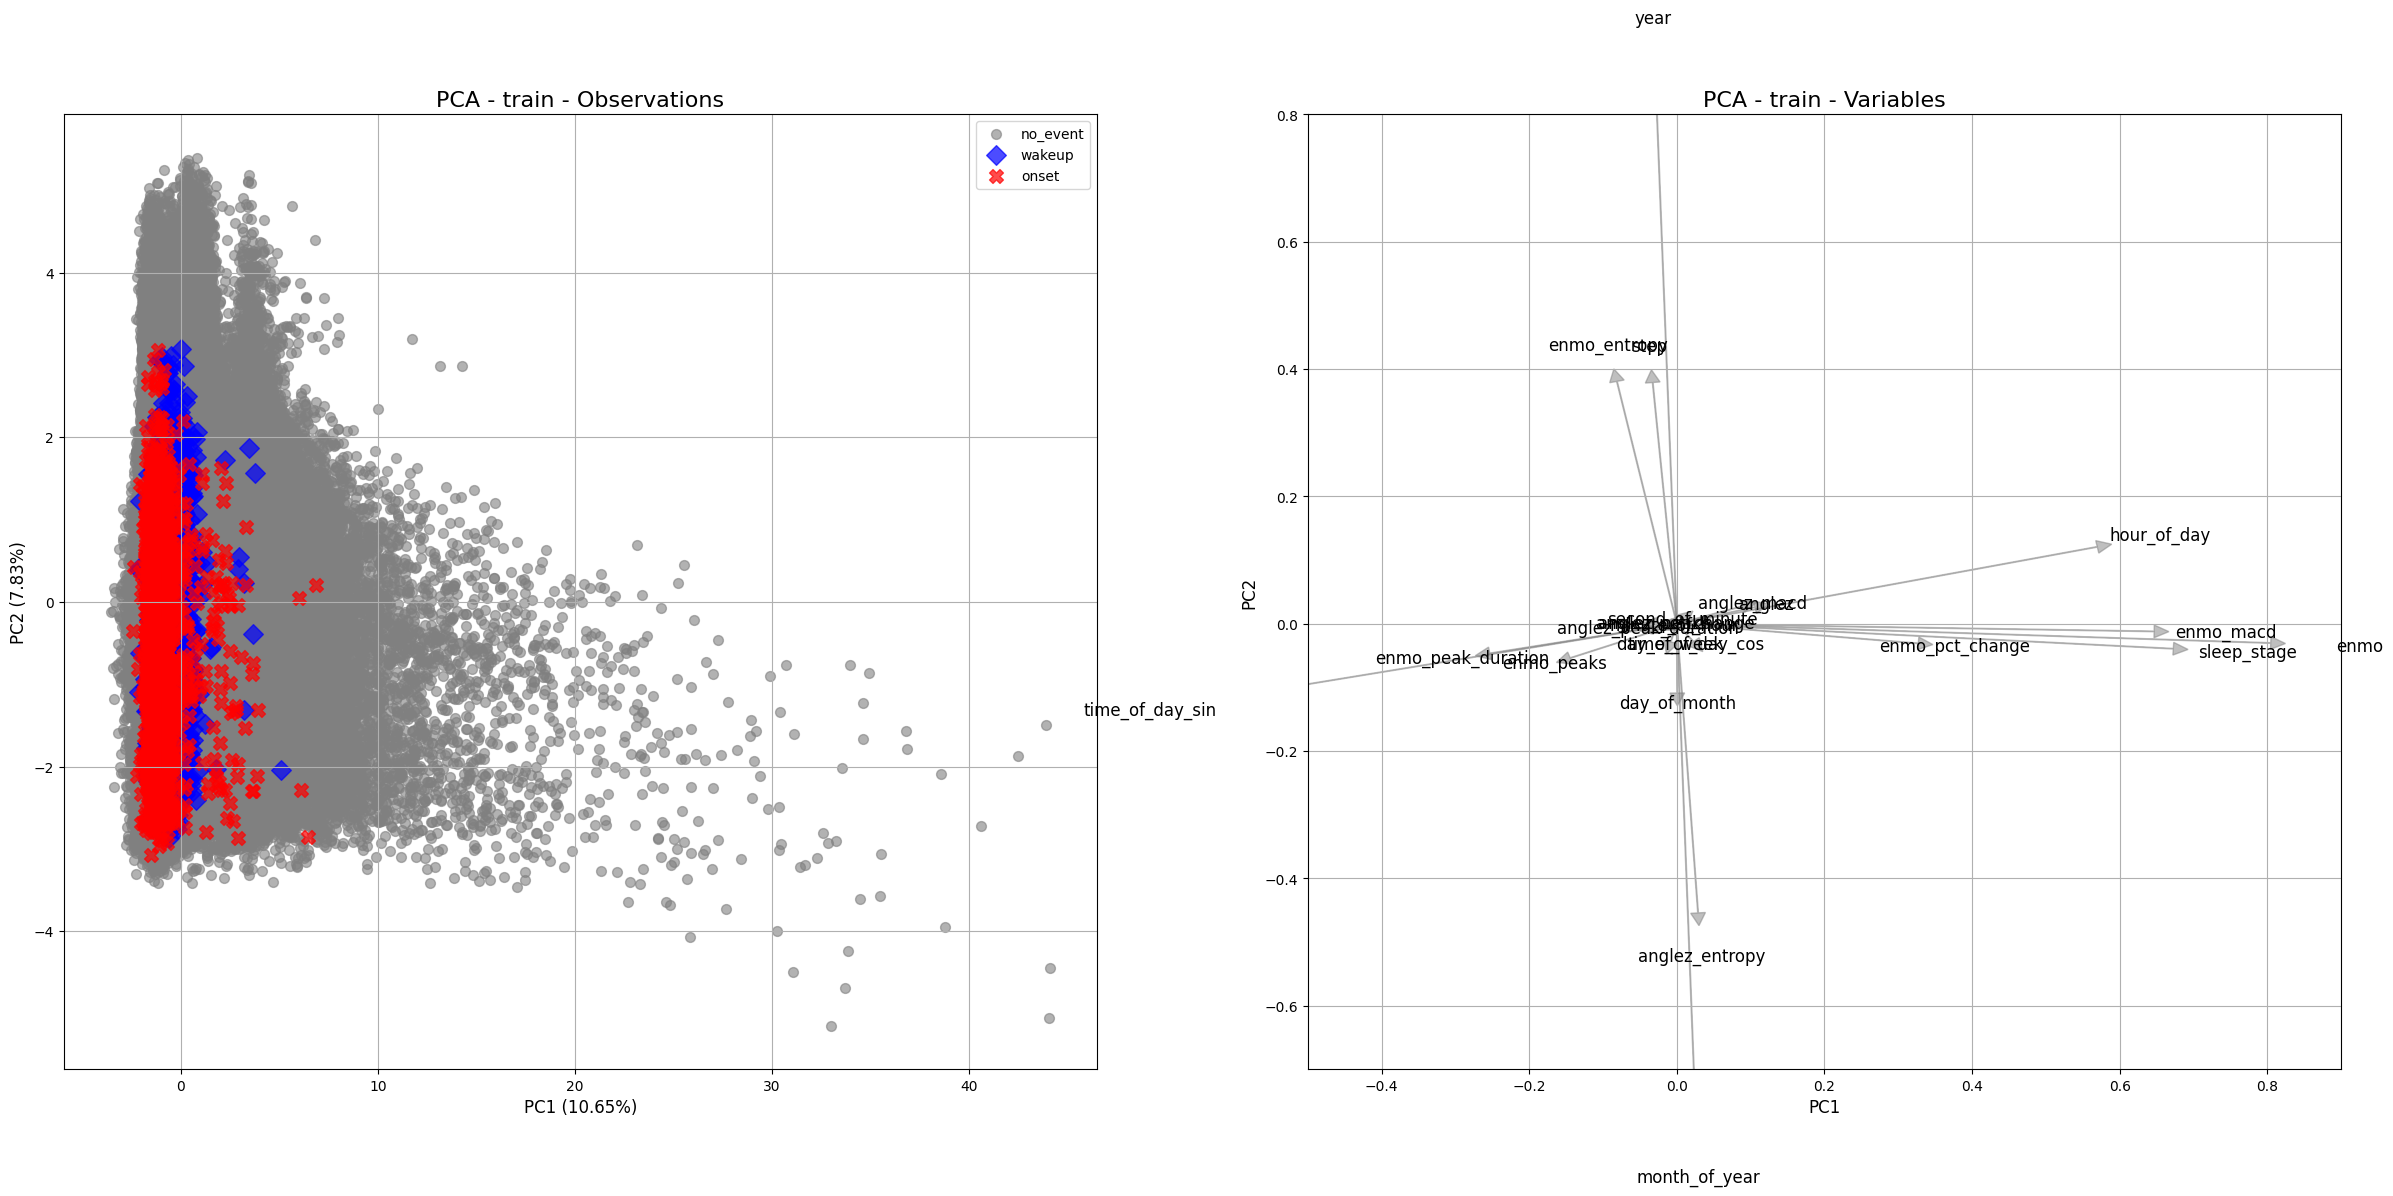

In [6]:
plot_pca(df)